In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder \
         .master("spark://192.168.1.71:7077") \
         .appName("Project") \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate()
        
sc = spark.sparkContext

# Chicago dataset
We used Crimes dataset from city of chicago portal and it contains many relevant information associated with each of the crime
that has occurred in chicago from year 2001 to till now. We are plotting 4 different graph associated with 4 different columns.
- Frequency of Crime type
- Frequency of Crime by Year
- Number of crimes by Month
- Number of crimes across location(This could help people know where they should be more careful)

In [75]:
#reading the csv file
df = spark.read.csv('Crimes.csv', header=True, inferSchema=True)

# Replication of data
Union was used in order to replicate the datasize for checking the scalability of spark cluster. 
We had two spark cluster, one with 1 node and the other with 4 nodes(1 master and 3 worker) to check the scalability.


In [64]:
#df2 is 2.9 gb
df2 = df.union(df)
#df3 is 5.8 gb
df3 = df2.union(df2)
#df4 is 11.6 gb
df4 = df3.union(df3)
#df5 is 23.2 gb
df5 = df4.union(df4)
df6 = df5.union(df4)

# Print RDD
For printing out the rdd on which map reduce has been performed

In [76]:
#For printing the rdd just paas the rdd object to print_rdd function
def print_rdd(output):
    for (word,count) in output.collect():
        print("%s: %i" % (word,count))
    

# Performing Map Reduce
Paas the dataframe to the below function and the column name which you want to reduce it. It will return the rdd object. It is also sorting the rdd on the basis of values in descending order

In [77]:
def map_reduce(df,x):
    crime_type = df.select(x)
    rddcrime = crime_type.rdd
    wordcounts= rddcrime.map(lambda w:(w,1)) \
        .reduceByKey(lambda a,b:a+b)\
        .sortBy(lambda x: -x[1])
    return wordcounts

# Plotting RDD
Use below function to plot the rdd.
- Arguments require are:
- ``rdd`` : rdd object which you want to plot
- ``x``: String appearing at x axis
-  ``y``: String appearing at y axis
-  `` width`` , ``height`` : width and height of the graph

In [78]:
def plotting_graph(rdd,x,y,width,height): 
    #Plotting the graph for number of crimes and frequency
    schemaPeople = spark.createDataFrame(rdd)

    #renaming the column in dataframe
    schemaPeople = schemaPeople.withColumnRenamed('_1',x)
    schemaPeople = schemaPeople.withColumnRenamed('_2',y)

    schemaPanda = schemaPeople.toPandas()
    schemaPanda.plot.bar(x =x, y =y, colormap = 'summer',figsize=(width,height))

# Mapping Crime Type
Performed map reduce on Primary Type columns. It returns the number of times the particular crime has occured in chicago
from year 2001 to till now

In [79]:
rdd = map_reduce(df,'Primary Type')
#print_rdd(rdd)

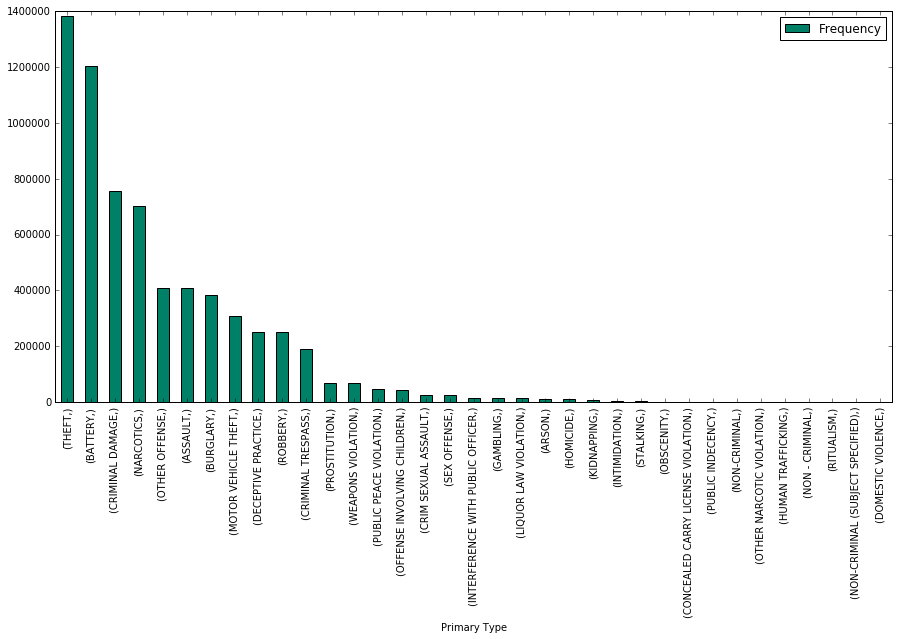

In [80]:
plotting_graph(rdd,'Primary Type','Frequency',15,7)

# Domestic Crimes
Percentage of the crimes that are domestic

In [81]:
df.filter(df['Domestic']==True).count()/df.count()*100

13.046469952759393

# Mapping Year
Plot for the crimes happening over the years

In [82]:
rdd2 = map_reduce(df,'Year')
#print_rdd(rdd2)

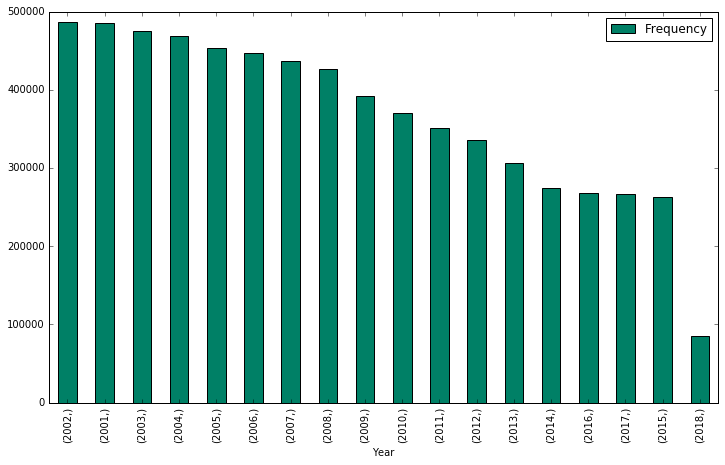

In [83]:
plotting_graph(rdd2,'Year','Frequency',12,7)


# Plotting Number of Crimes by Month
Using udf splitting date column and then returning month name according to the month number.

In [84]:
from pyspark.sql.functions import udf
def date_format(SicCodes_Str):
        m = SicCodes_Str.split('/')[0]
        if m == '01':
            return 'Jan'
        if m == '02':
            return 'Feb'
        if m == '03':
            return 'March'
        if m == '04':
            return 'April'
        if m == '05':
            return 'May'
        if m == '06':
            return 'June'
        if m == '07':
            return 'July'
        if m == '08':
            return 'August'
        if m == '09':
            return 'Sep'
        if m == '10':
            return 'Oct'
        if m == '11':
            return 'Nov'
        if m == '12':
            return 'Dec'
  

udf_date = udf(date_format, StringType())


df = df.withColumn("Month",udf_date("Date"))

df.select('Date','Month').show()

+--------------------+-----+
|                Date|Month|
+--------------------+-----+
|03/18/2015 07:44:...|March|
|03/18/2015 11:00:...|March|
|03/18/2015 10:45:...|March|
|03/18/2015 10:30:...|March|
|03/18/2015 09:00:...|March|
|03/18/2015 10:00:...|March|
|03/18/2015 11:00:...|March|
|03/18/2015 09:35:...|March|
|03/18/2015 10:09:...|March|
|03/18/2015 09:25:...|March|
|03/18/2015 09:30:...|March|
|03/15/2015 04:10:...|March|
|03/18/2015 09:14:...|March|
|03/18/2015 10:50:...|March|
|03/18/2015 10:31:...|March|
|03/18/2015 12:55:...|March|
|03/18/2015 08:00:...|March|
|03/18/2015 09:00:...|March|
|03/18/2015 10:56:...|March|
|03/18/2015 10:45:...|March|
+--------------------+-----+
only showing top 20 rows



In [85]:
rdd3 = map_reduce(df,'Month')
#print_rdd(rdd3)

# No of Crimes by Month

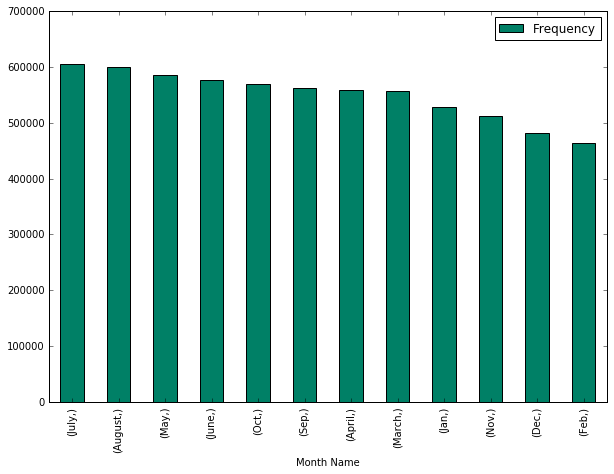

In [86]:
plotting_graph(rdd3,'Month Name','Frequency',10,7)

# Crime with Location
Next graph tells about where do most of the Crime take place. We used Location Description column for plotting the graph. There are 179 distinct Location Description so we are filtering out the location and taking only those location which has more than 17000 crimes reported. 

In [87]:
rdd4 = map_reduce(df,'Location Description')
rdd4 = rdd4.filter(lambda x: x[1]>17000)
#print_rdd(rdd4)

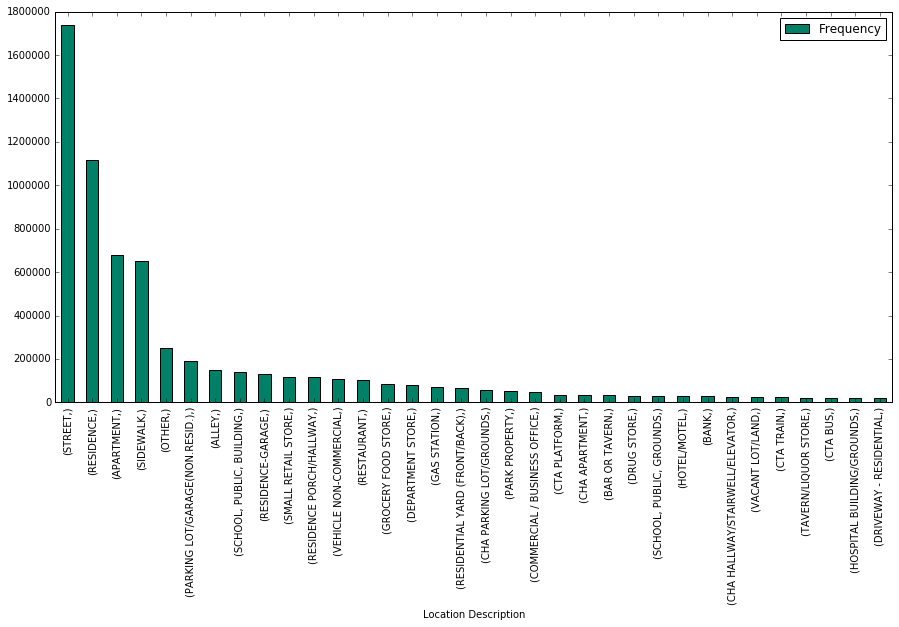

In [88]:
plotting_graph(rdd4,'Location Description','Frequency',15,7)

In [155]:
df.select("Date").show()

+--------------------+
|                Date|
+--------------------+
|03/18/2015 07:44:...|
|03/18/2015 11:00:...|
|03/18/2015 10:45:...|
|03/18/2015 10:30:...|
|03/18/2015 09:00:...|
|03/18/2015 10:00:...|
|03/18/2015 11:00:...|
|03/18/2015 09:35:...|
|03/18/2015 10:09:...|
|03/18/2015 09:25:...|
|03/18/2015 09:30:...|
|03/15/2015 04:10:...|
|03/18/2015 09:14:...|
|03/18/2015 10:50:...|
|03/18/2015 10:31:...|
|03/18/2015 12:55:...|
|03/18/2015 08:00:...|
|03/18/2015 09:00:...|
|03/18/2015 10:56:...|
|03/18/2015 10:45:...|
+--------------------+
only showing top 20 rows



In [73]:
spark.stop()